# Experiment Tracking

The machine learning life cycle involves training multiple algorithms using different hyperparameters and libraries, all with different performance results and trained models.  This lesson explores tracking those experiments to organize the machine learning life cycle.

### Tracking Experiments with MLflow

Over the course of the machine learning life cycle, data scientists test many different models from various libraries with different hyperparameters.  Tracking these various results poses an organizational challenge.  In brief, storing experiments, results, models, supplementary artifacts, and code creates significant challenges.

MLflow Tracking is one of the three main components of MLflow.  It is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

MLflow tracking also serves as a **model registry** so tracked models can easily be stored and, as necessary, deployed into production.

Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls.  This course will use Python, though the majority of MLflow functionality is also exposed in these other APIs.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

### Experiment Logging and UI

MLflow is an open source software project developed by Databricks available to developers regardless of which platform they are using.

!mlflow server --backend-store-uri mlruns/ --default-artifact-root mlruns/ --host 0.0.0.0 --port 5000

#### Import a dataset of Airbnb listings and featurize the data.  We'll use this to train a model.

In [1]:
!python --version

Python 3.8.1


In [2]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse, unquote
from os import listdir

#Sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

#Azure
import azureml.core
import azureml.dataprep
from azureml.core import Workspace, Dataset
from azure.storage.blob import BlobServiceClient
from azureml.core.authentication import ServicePrincipalAuthentication

#MLFlow
import mlflow
import mlflow.sklearn
from mlflow.entities import ViewType

#Temporarily filter all warning for demo
warnings.filterwarnings("ignore")

In [3]:
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.15.0


#### Update Working Directory

In [16]:
#current directory
os.getcwd()

'/Users/antfra/Desktop/MLFlow In Azure/notebooks'

In [13]:
# Get parent folder path
parent_directory=os.path.abspath("..")
parent_directory

'/Users/antfra/Desktop/MLFlow In Azure'

In [17]:
#Set parent path in system path list
sys.path.insert(0,parent_directory)
#Set current working directory as parent path
os.chdir(parent_directory)

## 0. The Data

##### New CWD

In [18]:
os.getcwd()

'/Users/antfra/Desktop/MLFlow In Azure'

In [20]:
data_path = "./data/wine-quality.csv" #put your path here
df = pd.read_csv(data_path)

df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1211,7.3,0.27,0.39,6.70,0.064,28.0,188.0,0.99580,3.29,0.30,9.7,5
2473,6.0,0.29,0.21,15.55,0.043,20.0,142.0,0.99658,3.11,0.54,10.1,6
6,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6
4215,7.0,0.44,0.24,12.10,0.056,68.0,210.0,0.99718,3.05,0.50,9.5,5
2272,6.2,0.25,0.28,8.50,0.035,28.0,108.0,0.99486,3.40,0.42,10.4,6
2154,9.8,0.93,0.45,8.60,0.052,34.0,187.0,0.99940,3.12,0.59,10.2,4
2536,6.5,0.23,0.25,17.30,0.046,15.0,110.0,0.99828,3.15,0.42,9.2,6
3716,6.8,0.22,0.26,1.20,0.041,29.0,182.0,0.99104,3.04,0.35,11.2,5
609,7.4,0.37,0.35,5.70,0.061,12.0,94.0,0.99650,3.48,0.69,10.7,6
924,7.9,0.28,0.41,2.00,0.044,50.0,152.0,0.99340,3.45,0.49,10.7,8


## 1. Tracking Experiments

#### List Experiments

In [23]:
mlflow.tracking.MlflowClient().list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

In [24]:
mlflow.create_experiment("My Simple New Experiment")
#output is the experiment_id

'1'

##### List Experiments (again)

In [25]:
mlflow.tracking.MlflowClient().list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1', experiment_id='1', lifecycle_stage='active', name='My Simple New Experiment', tags={}>]

### What do we track?

- **Code Version**: Git commit hash used for the run (if it was run from an MLflow Project)
- **Start & End Time**: Start and end time of the run
- **Source**: what code run?
- **Parameters**: Key-value input parameters.
- **Metrics**: Key-value metrics, where the value is numeric (can be updated over the run)
- **Artifacts**: Output files in any format.

### Execute A Run

In [58]:
def eval_metrics(actual,pred):
    #compute relevant metrics
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)
    return rmse, mae, r2

def data_prep(data):
    #pass dataframe
    #Split dataset to train and test dataframes
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["quality"], axis=1), data["quality"].values, random_state=42)
    return X_train, X_test, y_train, y_test

def train(data=df, alpha=0.5,l1_ratio=0.5,full_view=False,experiment_id='0'):
    #ignore warnings
    warnings.filterwarnings('ignore')
    #set random seed
    np.random.seed(87)
    
    #split data
    train_x,test_x,train_y,test_y=data_prep(df)
    
    
    #start MLFlow context manager
    with mlflow.start_run(experiment_id=experiment_id) as run:
        #train elastic_net model
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=87)
        lr.fit(train_x,train_y)
        
        #evaluate metrics
        test_pred=lr.predict(test_x)
        (rmse, mae, r2)=eval_metrics(test_y,test_pred)
        
        #print out metrics
        print(f'ElasticNet Model Params: alpha={alpha}, l1_ratio={l1_ratio}')
        print(f'RMSE: {rmse}')
        print(f"MAE: {mae}")
        print(f'R2: {r2}')
        
        #log parameters
        mlflow.log_param(key="alpha",value=alpha)
        mlflow.log_param(key="l1_ratio",value=l1_ratio)
        mlflow.log_param(key="r2",value=r2)
        mlflow.log_param(key="rmse",value=rmse)
        mlflow.log_param(key="mae",value=mae)
        
        # log model
        mlflow.sklearn.log_model(lr,"model")
        
        #print artifact uri
        print(f"Save To: {mlflow.get_artifact_uri()}")
        
        #print run_id
        print(f"Run ID: {run.info.run_uuid}")
        
        #print experiment id
        print(f"Experiment ID: {run.info.experiment_id}")
        
        #Print Full View of Runs
        if full_view:
            print(f"Run IDs: {mlflow.search_runs(ViewType.ACTIVE_ONLY)}")
        else:
            pass
        

### Start A New Run

In [33]:
train(data=df,alpha=0.5,l1_ratio=0.5)

ElasticNet Model Params: alpha=0.5, l1_ratio=0.5
RMSE: 0.821195103195106
MAE: 0.6338934920844772
R2: 0.1313572669551294
Save To: ./mlruns/0/c6b035e6f7584417b6966b2084bfa0c9/artifacts
Run ID: c6b035e6f7584417b6966b2084bfa0c9
Experiment ID: 0


In [35]:
train(data=df,alpha=0.6,l1_ratio=0.6)

ElasticNet Model Params: alpha=0.6, l1_ratio=0.6
RMSE: 0.8481727914656522
MAE: 0.6489712234815996
R2: 0.07334694474686643
Save To: ./mlruns/0/92342c1fd3d946b28262b1dcacd22087/artifacts
Run ID: 92342c1fd3d946b28262b1dcacd22087
Experiment ID: 0


In [36]:
train(data=df,alpha=0.4,l1_ratio=0.4)

ElasticNet Model Params: alpha=0.4, l1_ratio=0.4
RMSE: 0.8045164268812339
MAE: 0.6258958689316951
R2: 0.16628364535926987
Save To: ./mlruns/0/066ca247144c4e758609cdfe65bd6301/artifacts
Run ID: 066ca247144c4e758609cdfe65bd6301
Experiment ID: 0


In [39]:
train(data=df,alpha=0.6,l1_ratio=0.6,experiment_id='1') #switch to my new experiment 1

ElasticNet Model Params: alpha=0.6, l1_ratio=0.6
RMSE: 0.8481727914656522
MAE: 0.6489712234815996
R2: 0.07334694474686643
Save To: file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/31b639083855419fbb00e1ba3f687a5f/artifacts
Run ID: 31b639083855419fbb00e1ba3f687a5f
Experiment ID: 1


In [59]:
train(data=df,alpha=0.7,l1_ratio=0.1,experiment_id='1') #switch to my new experiment 1

ElasticNet Model Params: alpha=0.7, l1_ratio=0.1
RMSE: 0.800925432236956
MAE: 0.6242005649466131
R2: 0.1737096946650073
Save To: file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/5d44ba1c648d4cadb99e5acf7db47ddf/artifacts
Run ID: 5d44ba1c648d4cadb99e5acf7db47ddf
Experiment ID: 1


## 1.1 Compare Runs in UI

- Run `mlflow ui` in command line
- Open browser to specified local host url

## 1.2 Compare Runs Programmatically

### Look at MLFlow Directory Structure

This allows you to retrieve artifacts and run info.

In [60]:
from mlflow.tracking import MlflowClient

## Get list of experiments
exp_list=MlflowClient().list_experiments()
exp_list

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1', experiment_id='1', lifecycle_stage='active', name='My Simple New Experiment', tags={}>]

In [50]:
#main experiment
exp_id=exp_list[1].experiment_id

In [64]:
artifactURL = MlflowClient().get_experiment(exp_id).artifact_location

print("Artifact URL Root",artifactURL)

Artifact URL Root file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1


#### List Run Info for a given experiment

In [63]:
MlflowClient().list_run_infos(experiment_id=exp_id)

[<RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/5d44ba1c648d4cadb99e5acf7db47ddf/artifacts', end_time=1602178095942, experiment_id='1', lifecycle_stage='active', run_id='5d44ba1c648d4cadb99e5acf7db47ddf', run_uuid='5d44ba1c648d4cadb99e5acf7db47ddf', start_time=1602178095787, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/b53055c48dc34471aeaefe42b6950633/artifacts', end_time=1602178064238, experiment_id='1', lifecycle_stage='active', run_id='b53055c48dc34471aeaefe42b6950633', run_uuid='b53055c48dc34471aeaefe42b6950633', start_time=1602178064088, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/cee438b9deb04179a18b4d39f039b9a2/artifacts', end_time=1602178003410, experiment_id='1', lifecycle_stage='active', run_id='cee438b9deb04179a18b4d39f039b9a2', run_uuid='cee438b9deb04179a18b4d39f039b9a2', start_time=160217

Take a look at the contents of `model` above, which match what we see in the UI.

In [67]:
runID=MlflowClient().list_run_infos(experiment_id=exp_id)[0].run_id
runID

'5d44ba1c648d4cadb99e5acf7db47ddf'

In [69]:
artifacts_folderURL=artifactURL + "/" +runID+"/artifacts/"
print(artifacts_folderURL)

#Note: the default path format may need parsing depending on OS (ie removing '%' for spaces)
p = urlparse(artifacts_folderURL)
filename=unquote(p.path)

listdir(filename)[0]

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/5d44ba1c648d4cadb99e5acf7db47ddf/artifacts/


'model'

In [70]:
modelURL = artifactURL + "/" + runID + "/artifacts/" + str(listdir(filename)[0])
print(modelURL)
p = urlparse(modelURL)
filename=unquote(p.path)

listdir(filename)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/5d44ba1c648d4cadb99e5acf7db47ddf/artifacts/model


['MLmodel', 'model.pkl', 'conda.yaml']

### Parameters, Metrics, and Artifacts

But wait, there's more!  In the last example, you logged the run name, an evaluation metric, and your model itself as an artifact.  Now let's log parameters, multiple metrics, and other artifacts including the feature importances.

First, create a function to perform this.

In [75]:
train_x,test_x,train_y,test_y=data_prep(df)

In [78]:
def log_rf(experimentID, run_name, params, train_x, test_x, train_y, test_y):
  import os
  import matplotlib.pyplot as plt
  import mlflow.sklearn
  import seaborn as sns
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
  import tempfile

  with mlflow.start_run(experiment_id=experimentID, run_name=run_name) as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(**params)
    rf.fit(train_x, train_y)
    predictions = rf.predict(test_x)

    # Log model
    mlflow.sklearn.log_model(rf, "random-forest-model")

    # Log params
    [mlflow.log_param(param, value) for param, value in params.items()]

    # Create metrics
    mse = mean_squared_error(test_y, predictions)
    mae = mean_absolute_error(test_y, predictions)
    r2 = r2_score(test_y, predictions)
    print("  mse: {}".format(mse))
    print("  mae: {}".format(mae))
    print("  R2: {}".format(r2))

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)  
    
    # Create feature importance
    importance = pd.DataFrame(list(zip(df.columns, rf.feature_importances_)), 
                                columns=["Feature", "Importance"]
                              ).sort_values("Importance", ascending=False)
    
    # Log importances using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="feature-importance-", suffix=".csv")
    temp_name = temp.name
    print(temp_name)
    try:
      importance.to_csv(temp_name, index=False)
      mlflow.log_artifact(temp_name, "feature-importance.csv")
    finally:
      temp.close() # Delete the temp file
    
    # Create plot
    fig, ax = plt.subplots()

    sns.residplot(predictions, test_y, lowess=True)
    plt.xlabel("Predicted values for Quality ($)")
    plt.ylabel("Residual")
    plt.title("Residual Plot")

    # Log residuals using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="residuals-", suffix=".png")
    temp_name = temp.name
    print(temp_name)
    try:
      fig.savefig(temp_name)
      mlflow.log_artifact(temp_name, "residuals.png")
    finally:
      temp.close() # Delete the temp file
    
    print(run.info.run_uuid)
    display(fig)
    
    return run.info.run_uuid

Run with new parameters.

  mse: 0.49692080881346906
  mae: 0.5561292450318689
  R2: 0.35991791483414337
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/feature-importance-irwagsr9.csv
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/residuals-8odyok9h.png
7df589670391459ebeeb93c735d6fa84


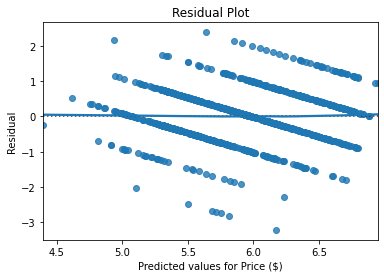

'7df589670391459ebeeb93c735d6fa84'

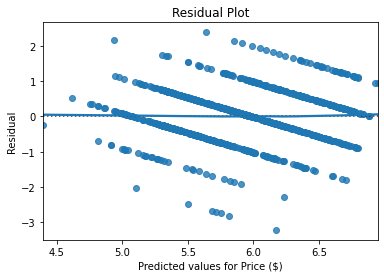

In [81]:
params = {
  "n_estimators": 100,
  "max_depth": 5,
  "random_state": 42
}

log_rf(exp_id, "Second Run", params, train_x, test_x, train_y, test_y)

Check the UI to see how this appears.  Take a look at the artifact to see where the plot was saved.

Now, run a third run.

  mse: 0.4173922811232713
  mae: 0.4942128644677261
  R2: 0.46235835389657887
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/feature-importance-m04mool_.csv
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/residuals-nt1mhj9e.png
61032a3c010c4f7aafe44da909fdc963


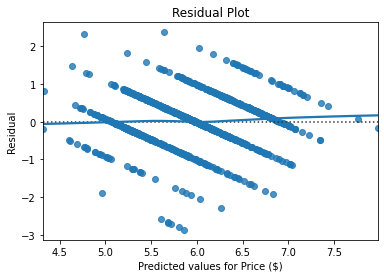

'61032a3c010c4f7aafe44da909fdc963'

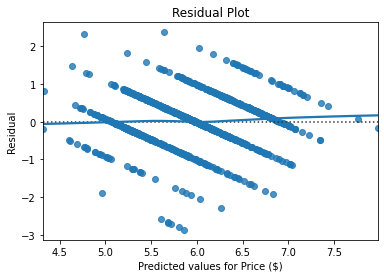

In [82]:
params_1000_trees = {
  "n_estimators": 1000,
  "max_depth": 10,
  "random_state": 42
}

log_rf(exp_id, "Third Run", params_1000_trees, train_x, test_x, train_y, test_y)

### Querying Past Runs

You can query past runs programatically in order to use this data back in Python.  The pathway to doing this is an `MlflowClient` object. 

In [83]:
from  mlflow.tracking import MlflowClient

client = MlflowClient()

Now list all the runs for your experiment using `.list_run_infos()`, which takes your `experiment_id` as a parameter.

In [85]:
client.list_run_infos(exp_id)

[<RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/61032a3c010c4f7aafe44da909fdc963/artifacts', end_time=1602181381299, experiment_id='1', lifecycle_stage='active', run_id='61032a3c010c4f7aafe44da909fdc963', run_uuid='61032a3c010c4f7aafe44da909fdc963', start_time=1602181370949, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/7df589670391459ebeeb93c735d6fa84/artifacts', end_time=1602181321942, experiment_id='1', lifecycle_stage='active', run_id='7df589670391459ebeeb93c735d6fa84', run_uuid='7df589670391459ebeeb93c735d6fa84', start_time=1602181320848, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/66f8fdda82ea408c85c0c81985ba169c/artifacts', end_time=1602181189609, experiment_id='1', lifecycle_stage='active', run_id='66f8fdda82ea408c85c0c81985ba169c', run_uuid='66f8fdda82ea408c85c0c81985ba169c', start_time=160218

Pull out a few fields and create a pandas DataFrame with it.

In [86]:
runs = pd.DataFrame([(run.run_uuid, run.start_time, run.artifact_uri) for run in client.list_run_infos(exp_id)])
runs.columns = ["run_uuid", "start_time", "artifact_uri"]

display(runs)

,run_uuid,start_time,artifact_uri
0,61032a3c010c4f7aafe44da909fdc963,1602181370949,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
1,7df589670391459ebeeb93c735d6fa84,1602181320848,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
2,66f8fdda82ea408c85c0c81985ba169c,1602181188133,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
3,f9d6b0a22f8b474b827e0bb09e40dda6,1602181026521,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
4,caa66357fee4417992fb223dcda85e6d,1602180969108,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
5,5d44ba1c648d4cadb99e5acf7db47ddf,1602178095787,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
6,b53055c48dc34471aeaefe42b6950633,1602178064088,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
7,cee438b9deb04179a18b4d39f039b9a2,1602178003252,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
8,31b639083855419fbb00e1ba3f687a5f,1602175010787,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...


Pull the last run and take a look at the associated artifacts.

In [87]:
last_run = runs.sort_values("start_time", ascending=False).iloc[0]

print(last_run.artifact_uri+ "/random-forest-model/")

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/61032a3c010c4f7aafe44da909fdc963/artifacts/random-forest-model/


In [88]:
#transform URI into a path
p = urlparse(last_run.artifact_uri+ "/random-forest-model/")
filename=unquote(p.path)

listdir(filename)

['MLmodel', 'model.pkl', 'conda.yaml']

Return the evaluation metrics for the last run.

In [89]:
client.get_run(last_run.run_uuid).data.metrics

{'mae': 0.4942128644677261,
 'mse': 0.4173922811232713,
 'r2': 0.46235835389657887}

In [90]:
client.get_run(last_run.run_uuid)

<Run: data=<RunData: metrics={'mae': 0.4942128644677261,
 'mse': 0.4173922811232713,
 'r2': 0.46235835389657887}, params={'max_depth': '10', 'n_estimators': '1000', 'random_state': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "61032a3c010c4f7aafe44da909fdc963", '
                             '"artifact_path": "random-forest-model", '
                             '"utc_time_created": "2020-10-08 '
                             '18:23:00.499370", "flavors": {"python_function": '
                             '{"model_path": "model.pkl", "loader_module": '
                             '"mlflow.sklearn", "python_version": "3.8.1", '
                             '"env": "conda.yaml"}, "sklearn": '
                             '{"pickled_model": "model.pkl", '
                             '"sklearn_version": "0.23.2", '
                             '"serialization_format": "cloudpickle"}}}]',
 'mlflow.runName': 'Third Run',
 'mlflow.source.git.commit': '70635dade88cc31365a8a0b2275b639

Reload the model and take a look at the feature importance.

In [91]:
print(last_run.artifact_uri)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/mlruns/1/61032a3c010c4f7aafe44da909fdc963/artifacts


In [92]:
import mlflow.sklearn

model = mlflow.sklearn.load_model(last_run.artifact_uri + "/random-forest-model/")
model.feature_importances_

array([0.0550671 , 0.13997047, 0.04915428, 0.05951664, 0.05137144,
       0.12424812, 0.05274532, 0.04767693, 0.06316617, 0.05142996,
       0.30565357])